In [0]:
# To install cupy

!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8926      0 --:--:-- --:--:-- --:--:--  8926
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:
import cupy as cp
import numpy as np
import random
import time 
import matplotlib.pyplot as plt
import matplotlib
from __future__ import print_function

In [0]:
# Some hyper parameters
GAP_SCORE = -8

# Gap extended: https://web.stanford.edu/class/cs262/presentations/lecture2.pdf
EGAP_SCORE = 0

MATCH_SCORE_TWO_SEQ = 60

#Clean with MATCH_SCORE_TWO_SEQ = 30 and GAP_SCORE = -8

In [0]:
################################################################
################################################################


import numpy as np
from sympy import binomial
import os
from __future__ import print_function

def arrayPositionInMatrix(len_sequence):
    """
    
    Creates a 1D arrays which indicate for each time step the position 
    of the cells to compute in a Needleman and Wunch flattened matrix. 
    Works only for the alignment of 2 sequences with the same size.
    
    Parameters
    ----------
    len_sequence: int
        The size of the sequences which are aligned.
      
    number_cells_computed: 1D array
        Array which indicate the cumulative total number of cells computed 
        at each time step.
    
    Returns
    -------
    position_in_nw_flatten_matrix: 1D array
        Array which indicate the position of the cells to compute in a Needleman
        and Wunch flattened matrix.
    """
    
    number_steps = 2 * len_sequence - 1  # We can know the number of time steps to entirely compute the NW matrix with the theorie
    shape_matrix = ((len_sequence + 1, len_sequence + 1)) # The "+ 1" to not be bothered with the boundaries

    position_x = [0] # position x of the elements which are computed in a 3D matrix
    position_y = [0] # position y of the elements which are computed in a 3D matrix

    position_in_nw_flatten_matrix = np.zeros(shape=((len_sequence)**2, ), dtype=np.int32)
    # Needleman and Wunch matrix flattened 


    interval1 = 0
    cumul_cells = [interval1]

    for time in range(1, number_steps + 1):
        print("\r{} / {}".format(time, number_steps), end='')
        position_cells_to_compute = np.vstack((position_x, position_y))
        #print(position_cells_to_compute)
        #print("")


         
        #interval1 = number_cells_computed[time-1]
        #interval2 = number_cells_computed[time]

        interval2 = interval1 + position_cells_to_compute.shape[1]

        position_in_nw_flatten_matrix[interval1:interval2] = np.ravel_multi_index(position_cells_to_compute + 1, shape_matrix) # The "+ 1" to not be bothered with the boundaries

        interval1 = interval2
        cumul_cells.append(interval1)

        ## We update the position of the cells to compute for the next time step
        """
        if (time < len_sequence):
            position_x.append(time)
            position_y.insert(0, time)

        else:
            position_x.pop(0)
            position_y.pop()
        """
        time2 = time + 1
        if (time2 < len_sequence):
          boundarie = min(time2, len_sequence)
          a = np.arange(boundarie)
          b = np.arange(boundarie - 1, -1, -1)
        else:
          boundarie = min(time2, len_sequence)
          a = np.arange(time2 - len_sequence, boundarie)
          b = np.arange(boundarie - 1, time2 - len_sequence - 1, -1)

        position_x = a[abs(a - b) < (len_sequence // 5)]
        position_y = b[abs(a - b) < (len_sequence // 5)]


        #print(position_x)
        #print(position_y)
        #a = np.asarray(position_x, dtype=np.int64)
        #b = np.asarray(position_y, dtype=np.int64)

        #position_x = list(a[abs(a - b) < 3])
        #position_y = list(b[abs(a - b) < 3])

        


    if (cumul_cells[len(cumul_cells)-1] == cumul_cells[len(cumul_cells)-2]):
      cumul_cells.pop()

    position_in_nw_flatten_matrix = position_in_nw_flatten_matrix[position_in_nw_flatten_matrix > 0]
    return cumul_cells, position_in_nw_flatten_matrix
  

len_sequence = 900 # Enter the sequence you want here
len_sequence += 1 # The sequences which are aligned have a size len_sequence + 1 because we add a gap element at the beginning of the sequences
#print(time_step_computed)
cumul_cells, position_in_nw_flatten_matrix = arrayPositionInMatrix(len_sequence)

nb_cells_not_computed = len_sequence**2 - len(position_in_nw_flatten_matrix)
print("\nNumber of cells not computed: {}, ({}%)".format(nb_cells_not_computed, (float(nb_cells_not_computed) / (len_sequence**2)) * 100.))

########################################################################
##########################################################################

1801 / 1801
Number of cells not computed: 520562, (64.1243358902%)


In [0]:
print("\nSAVING THE POSITION OBTAINED")

name_directory = "2D_lenSeq_" + str(len_sequence)
!mkdir $name_directory

np.save(name_directory + "/position_cells_to_compute", position_in_nw_flatten_matrix) # M^N SPACE
np.save(name_directory + "/number_cells_computed", cumul_cells) # M*N SPACE

print("END OF SAVING")


SAVING THE POSITION OBTAINED
END OF SAVING


In [0]:
"""

Get a particular score for each cells that you want to compute in the Needleman 
and Wunch matrix by comparing if the characteres associate to a cell are identical

Parameters
----------
chars_depth: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the depth charactere in the matrix
    
chars_line: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the line charactere in the matrix
    
chars_column: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the column charactere in the matrix
    
    
Returns
-------
1D array
    An array of the same size than the arrays in input where each elements of 
    this array has an information which tell if the charactere are identical
    and which one are identical

"""

def getScore(chars_line, chars_column):
    return MATCH_SCORE_TWO_SEQ - cp.abs(chars_line - chars_column) # Maximum : MATCH_SCORE_TWO_SEQ (if pixel line and pixel column are equal) and minimum : MATCH_SCORE_TWO_SEQ - 255 (if abs(pixel line - pixel column = 255))

In [0]:
"""

Compute the Needleman and Wunch matrix for the comparaison of three sequences.

Parameters
----------
seq1, seq2, seq3: 1D array
    arrays of number where each number represent a DNA character. The first elements
    of the sequence must be the gap characere and be different for each sequences.
    
pos_in_seq1, pos_in_seq2, pos_in_seq3: 1D array
    arrays which indicate which character to compare for each cell in the Needleman
    and wunch algorithm.
    
cumul_nb_cells_computed: 1D array
    array which indicate the cumulative number of cells computed at each time step
    
position_in_nw_flatten_matrix: 1D array
    array which indicate the position of the cells to compute in a flatten 
    Needleman and Wunch matrix. The first element indicate the position 
    of the first cell to compute, the second element indicate the position
    of the second cell to compute...
    
Returns
-------
nw_matrix: 3D array
    The Needleman and Wunch matrix computed.
    
time_taken_each_step: list
    A list where each element of index i indicate the time passed to compute
    all the cells at the time step i.
    
    
    
IT IS QUICKER IF WE USE GLOBAL VAR INSTEAD OF PASSING VAR TO FUNCTION
THIS IS WHY THIS IS COMMENTED

"""

def computeScoringMatrix(seq1, seq2):#, pos_in_seq1, pos_in_seq2, pos_in_seq3, cumul_nb_cells_computed, position_in_nw_flatten_matrix):
    time_taken_each_step = []
    len_sequence = len(seq1)
    nw_matrix = cp.full((len_sequence + 1, len_sequence + 1), len_sequence*GAP_SCORE, dtype=cp.int32) # Extend the length of each dimension by one in the needleman and Wunch matrix to not have problem wth boundaries


    nw_matrix[0, :] = nw_matrix[:, 0] = len_sequence*GAP_SCORE # Fill those boundaries with values which will never be choosen
    #nw_matrix[0, 0] = 
    nw_matrix[1, 1] = 0


    nw_matrix_flatten = nw_matrix.ravel()
    G = nw_matrix_flatten.copy()
    H = nw_matrix_flatten.copy()
    shapeMatrix = nw_matrix.shape
    total_number_steps = 2 * len_sequence - 1 # See the theorie to understand why the number of time step is that




    for step in range(2, total_number_steps + 1):
        begin = time.time()
        print("\r{} / {}".format(step, total_number_steps), end='')

        interval1 = cumul_nb_cells_computed[step-1]
        interval2 = cumul_nb_cells_computed[step]
        
        
        pos_cells_to_compute = position_in_nw_flatten_matrix[interval1:interval2]

        state_matrix = getScore(seq1[pos_in_seq1[interval1:interval2]], seq2[pos_in_seq2[interval1:interval2]])

        #score_cells_line_minus1 = nw_matrix_flatten[pos_cells_to_compute - (len_sequence+1)]
        #score_cells_column_minus1 = nw_matrix_flatten[pos_cells_to_compute - 1]
        #max_minus_one_dim = cp.maximum(score_cells_line_minus1, score_cells_column_minus1) + GAP_SCORE
        
        G[pos_cells_to_compute] = cp.maximum(nw_matrix_flatten[pos_cells_to_compute - (len_sequence+1)] + GAP_SCORE, G[pos_cells_to_compute - (len_sequence+1)] + EGAP_SCORE)
        H[pos_cells_to_compute] = cp.maximum(nw_matrix_flatten[pos_cells_to_compute - 1] + GAP_SCORE, H[pos_cells_to_compute - 1] + EGAP_SCORE)
        max_minus_one_dim = cp.maximum(G[pos_cells_to_compute], H[pos_cells_to_compute])
        

        score_cells_line_column_minus1 = nw_matrix_flatten[pos_cells_to_compute - (len_sequence+1) - 1]
        score_cells_line_column_minus1 +=  state_matrix
        """
        print("")
        print(max_minus_one_dim)
        print(score_cells_line_column_minus1)
        print("")
        if (step == 4):
          return
        """
        


        # We put the maximum value in the matrix:
        nw_matrix_flatten[pos_cells_to_compute] = cp.maximum(max_minus_one_dim, score_cells_line_column_minus1)


        end = time.time()
        time_taken_each_step.append(end - begin)
    return nw_matrix, time_taken_each_step, G, H

In [0]:
"""
Converts a tuple of index arrays into an array of flat indices (just in dimmension 2)
Inputs : index: tuple of index arrays
shape : shape of the matrix
(See numpy : tuple_multi_index for more precision (this function is not implemented in cupy))
"""

def ravel_multi_index(index, shape): # Ne marche qu'en dimension 2
  return index[0][0] * shape[1] + index[1][0]

In [0]:
"""

Backtrack the Needleman and Wunch algorithm to find the optimal path

Parameters
----------
nw_matrix: 3D array
    The Needleman and Wunch matrix computed
    
    
Returns
-------
path: list of (3, 1) array
    A list of the optimal path where each element of the list contain the 
    depth, line and column position of the matrix
    
NOTE
--------
We use numpy instead of cupy because we compute one cell each time, so the CPU is 
much faster than the GPU for that kind of task.
    

"""


def determinatePath(nw_matrix, G, H):
    shapeMatrix = nw_matrix.shape
    #a = np.zeros((3, ))
    a = np.zeros((5, ))
    vector_path = np.zeros((2, 1), np.int32)
    vector_path[0] = vector_path[1] = shapeMatrix[0] - 1
    path = []

    nw_matrix_flatten = nw_matrix.flatten()
    new_path = np.array([ [[1], [0]], [[0], [1]], [[1], [1]]  ])
    
   #Mask column :

    vector_mask_line = np.zeros((2, 1) ,np.int32)
    vector_mask_line[0][0] = 1

    vector_mask_column = np.zeros((2, 1), np.int32)
    vector_mask_column[1][0] = 1

    vector_mask_line_column = np.ones((2, 1), np.int32)



    while(1):
        path.append(vector_path)

        cell_to_backtrack = nw_matrix_flatten[ravel_multi_index(vector_path, shapeMatrix)]

        a[0] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_line, shapeMatrix)] + GAP_SCORE
        a[1] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_column, shapeMatrix)] + GAP_SCORE
        a[2] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_line_column, shapeMatrix)] + MATCH_SCORE_TWO_SEQ - np.abs(u1[vector_path[0][0]-1] - u2[vector_path[1][0] - 1])
        
        a[3] = G[ravel_multi_index(vector_path - vector_mask_line, shapeMatrix)] + EGAP_SCORE
        a[4] = H[ravel_multi_index(vector_path - vector_mask_column, shapeMatrix)] + EGAP_SCORE
        
        
        pathTest = np.equal(a, cell_to_backtrack)
        index = np.argmax(pathTest)
        if (index == 3):
          index = 0
        elif (index == 4):
          index = 1
        vector_path = vector_path - new_path[index]
        if (np.any(pathTest) == False or vector_path[0][0] == vector_path[1][0] == 1):
            path.append(vector_path)
            #print("FINISH")
            return path


    return

In [0]:
"""

Use the optimal path to align the three sequences

Parameters
----------

seq1, seq2, seq3: list
  The three sequences.

path: list of arrays of shape (3, 1)
    The optimal path in the Needleman and Wunch matrix.
    
    
"""



def alignSequences(seq1, seq2, path):

    S1final =  list(seq1[:])
    S2final =  list(seq2[:])

    #print(S1final)
    #print(S2final)

    path = path[::-1]

    for i in range(len(path) - 1):
        p = path[i+1] - path[i]
        if (p[0][0] == 0):
            S1final.insert(i, '-')
        if (p[1][0] == 0):
            S2final.insert(i, '-')

    #print(S1final)
    #print(S2final)
    
    return S1final, S2final

original size of the figure: (900, 750)
We resize the figure in : (900, 750)


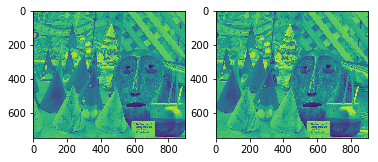

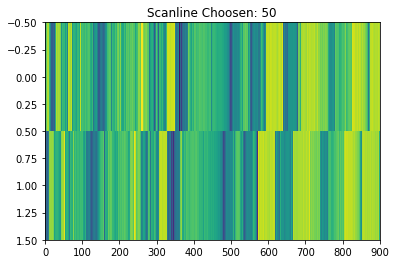

'\na = np.random.rand(3, 3)\na[0] = np.array([84, 150, 60])\na[1] = np.array([92, 13, 162])\na[2] =  np.array([21, 145, 52])\nplt.imshow(a)\n'

In [0]:
#Load image:
from PIL import Image
import matplotlib.pyplot as plt


imgLeft = Image.open('./im3.ppm').convert('L')
imgRight = Image.open('./im5.ppm').convert('L')

a = imgLeft.size
print("original size of the figure: {}".format(a))
reshapeSize = (a[0] , a[1])
print("We resize the figure in : {}".format(reshapeSize))

imgLeft = imgLeft.resize(reshapeSize, Image.ANTIALIAS)
imgRight = imgRight.resize(reshapeSize, Image.ANTIALIAS)

numpyLeftImg = np.asarray(imgLeft)
numpyRightImg = np.asarray(imgRight)


#numpyLeftImg = numpyLeftImg[450:550, :]
#numpyRightImg = numpyRightImg[450:550, :]



scanlineChoosen = 50


# Let's begin with a size of 100 for test

numpyLeftImg = numpyLeftImg
numpyRightImg = numpyRightImg

plt.figure()
plt.subplot(121)
plt.imshow(numpyLeftImg)
plt.subplot(122)
plt.imshow(numpyRightImg)
plt.show()




a = np.full((2, numpyLeftImg.shape[1]), 0)
a[0, :] = numpyLeftImg[scanlineChoosen, :]
a[1:, :] = numpyRightImg[scanlineChoosen, :]
plt.title("Scanline Choosen: " + str(scanlineChoosen))
plt.imshow(a, interpolation='nearest', aspect='auto')
plt.show()



#plt.imshow(numpyMiddleImg)
#plt.imshow(numpyRightImg)




#a = np.random.rand(2, 5)
#a[0] = np.array([0, 30, 140, 40, 0])
#a[1] = np.array([30, 140, 0, 40, 0])
#plt.imshow(a)



"""
a = np.random.rand(3, 4)
a[0] = np.array([84, 150, 60, 21])
a[1] = np.array([92, 13, 72, 162])
a[2] =  np.array([21, 90, 148, 20])
plt.imshow(a)
"""

#With size 3, it works !
"""
a = np.random.rand(3, 3)
a[0] = np.array([84, 150, 60])
a[1] = np.array([92, 13, 162])
a[2] =  np.array([21, 145, 52])
plt.imshow(a)
"""

In [0]:
# The main 

lenSequence = 900
lenSequence += 1 # To add the gap at the beginning of the sequences.



print("I BEGIN TO LOAD")
cumul_nb_cells_computed = cp.load("./2D_lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./2D_lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

#pos_in_seq1 = cp.full((lenSequence**2, ), -1)
pos_in_seq1 = cp.asarray(position_in_nw_flatten_matrix // (lenSequence+1) - 1)

#pos_in_seq2 = cp.full((lenSequence**2, ), -1)
pos_in_seq2 = cp.asarray(position_in_nw_flatten_matrix % (lenSequence+1) - 1)


print("FINISH TO LOAD")


seq1 = numpyLeftImg[scanlineChoosen, :]
seq2 = numpyRightImg[scanlineChoosen, :]
#seq1 = a[0]
#seq2 = a[1]

print(seq1.shape)


sequenceNumber1 = seq1
sequenceNumber2 = seq2



u1 = cp.empty((lenSequence, ), dtype=cp.int32)
u1[0] = 0 #-256*2-1
u1[1:] = cp.array(seq1)

u2 = cp.empty((lenSequence, ), dtype=cp.int32)
u2[0] = 0 # -256*3-1
u2[1:] = cp.array(seq2)

print(u1.shape)
print(u2.shape)

print(u1)
print(u2)


I BEGIN TO LOAD
FINISH TO LOAD
(900,)
(901,)
(901,)
[  0 114 124 143 150 151 158 169 170 170 168 166 161 138 123 109  99  93
  83  78  77  83  94  90  88  84  83 100 114 131 162 169 168 166 164 165
 166 168 167 166 164 163 158 146 120 117 131 137 140 137 137 139 137 138
 141 136 123 126 136 135 119 105 140 170 173 172 170 169 169 166 161 181
 173 116 118 144 140 135 137 139 135 134 131 100 103 124 140 142 138 138
 139 138 138 130 133 152 173 178 151 140 145 144 141 140 141 144 142 139
 140 145 141 141 138 139 142 142 145 146 145 142 145 144 138 132 130 127
 124 134 138 136 121  97 105 114 113 117 119 125 130 122 111 104 102  94
  81  81  82  82  87  94  97 104 101  97  93  94 102  95  88  91  94 106
 112 111 111 113 119 134 141 143 142 145 144 144 149 147 146 149 149 108
  95 136 139 134 129 134 133 132 132 134 145 159 146 137 152 155 154 154
 157 147 147 144 151 160 146 139 132 139 138 127 127 127 131 134 142 126
  99 132 145 149 145 142 146 147 150 149 147 144 142 148 150 143 147 149

In [0]:
    start = time.time()

    print("COMPUTE SCORE MATRIX : ")
    nw_matrix, time_taken_each_step, G, H = computeScoringMatrix(u1, u2)#, pos_in_seq1, pos_in_seq2, pos_in_seq3, cumul_nb_cells_computed, position_in_nw_flatten_matrix)
    #print(nw_matrix)

    end = time.time()
    print("\nTime to calculate the Needleman and Wunch matrix : {} seconds".format(end - start))

COMPUTE SCORE MATRIX : 
1801 / 1801
Time to calculate the Needleman and Wunch matrix : 3.21222901344 seconds


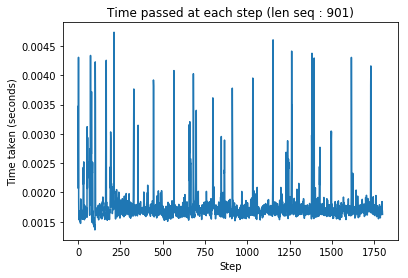

Mean : 0.0017817684014638266
Var : 1.313241629947331e-07


In [0]:
plt.plot(list(cp.arange(len(time_taken_each_step))), time_taken_each_step)
plt.title("Time passed at each step (len seq : " + str(lenSequence) + ")")
plt.xlabel("Step")
plt.ylabel("Time taken (seconds)")
plt.show()

arrayTempsPasseAtEachStep = cp.asarray(time_taken_each_step[:])
print("Mean : {}\nVar : {}".format(arrayTempsPasseAtEachStep.mean(), arrayTempsPasseAtEachStep.var()))


DETERMINATE PASS : 
(902, 902)
ALIGN SEQUENCES : 

Time to baktrack the Needleman and Wunch matrix and align the sequences: 0.252378940582 seconds
[114, 124, 143, 150, 151, 158, 169, 170, 170, 168, 166, 161, 138, 123, 109, 99, 93, 83, 78, 77, 83, 94, 90, 88, 84, 83, 100, 114, 131, 162, 169, 168, 166, 164, 165, 166, 168, 167, 166, 164, 163, 158, 146, 120, 117, 131, 137, 140, 137, 137, 139, 137, 138, 141, 136, 123, 126, 136, 135, 119, 105, 140, 170, 173, 172, 170, 169, 169, 166, 161, 181, 173, 116, 118, 144, 140, 135, 137, 139, 135, 134, 131, 100, 103, 124, 140, 142, 138, 138, 139, 138, 138, 130, 133, 152, 173, 178, 151, 140, 145, 144, 141, 140, 141, 144, 142, 139, 140, 145, 141, 141, 138, 139, 142, 142, 145, 146, 145, 142, 145, 144, 138, 132, 130, 127, 124, 134, 138, 136, 121, 97, 105, 114, 113, 117, 119, 125, 130, 122, 111, 104, 102, 94, 81, 81, 82, 82, 87, 94, 97, 104, 101, 97, 93, 94, 102, 95, 88, 91, 94, 106, 112, 111, 111, 113, 119, 134, 141, 143, 142, 145, 144, 144, 149, 147, 146,

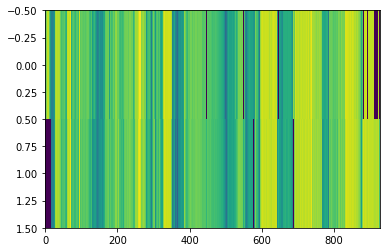

Len seq : 900


In [0]:
  #print(nw_matrix)
  begin = time.time()
  print("DETERMINATE PASS : ")
  print(nw_matrix.shape)
  path = determinatePath(cp.asnumpy(nw_matrix), cp.asnumpy(G), cp.asnumpy(H))
  #print(path)

  print("ALIGN SEQUENCES : ")
  S1final, S2final = alignSequences(seq1, seq2, path)
  end = time.time()
  print("\nTime to baktrack the Needleman and Wunch matrix and align the sequences: {} seconds".format(end - begin))
  
  print(S1final)
  print(S2final)
  
   # print the align sequences:
  for i in range(len(S1final)):
    if (S1final[i] == '-'):
      S1final[i] = 0

  for i in range(len(S2final)):
    if (S2final[i] == '-'):
      S2final[i] = 0
      
      
  a = np.full((2, max(len(S1final), len(S2final))), 0)
  a[0, :len(S1final)] = np.array(S1final, dtype=np.int32)
  a[1, :len(S2final)] = S2final
  plt.imshow(a, interpolation='nearest', aspect='auto')
  plt.show()
  print("Len seq : {}".format(len(seq1)))

I BEGIN TO LOAD
FINISH TO LOAD

Scanline : 0 / 750
1801 / 1801

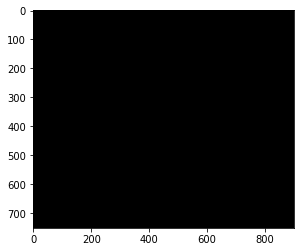


Scanline : 1 / 750
1801 / 1801
Scanline : 2 / 750
1801 / 1801
Scanline : 3 / 750
1801 / 1801
Scanline : 4 / 750
1801 / 1801
Scanline : 5 / 750
1801 / 1801
Scanline : 6 / 750
1801 / 1801
Scanline : 7 / 750
1801 / 1801
Scanline : 8 / 750
1801 / 1801
Scanline : 9 / 750
1801 / 1801
Scanline : 10 / 750
1801 / 1801
Scanline : 11 / 750
1801 / 1801
Scanline : 12 / 750
1801 / 1801
Scanline : 13 / 750
1801 / 1801
Scanline : 14 / 750
1801 / 1801
Scanline : 15 / 750
1801 / 1801
Scanline : 16 / 750
1801 / 1801
Scanline : 17 / 750
1801 / 1801
Scanline : 18 / 750
1801 / 1801
Scanline : 19 / 750
1801 / 1801
Scanline : 20 / 750
1801 / 1801

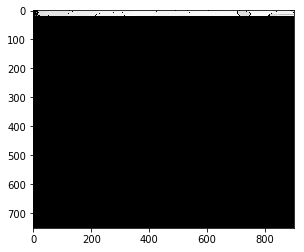


Scanline : 21 / 750
1801 / 1801
Scanline : 22 / 750
1801 / 1801
Scanline : 23 / 750
1801 / 1801
Scanline : 24 / 750
1801 / 1801
Scanline : 25 / 750
1801 / 1801
Scanline : 26 / 750
1801 / 1801
Scanline : 27 / 750
1801 / 1801
Scanline : 28 / 750
1801 / 1801
Scanline : 29 / 750
1801 / 1801
Scanline : 30 / 750
1801 / 1801
Scanline : 31 / 750
1801 / 1801
Scanline : 32 / 750
1801 / 1801
Scanline : 33 / 750
1801 / 1801
Scanline : 34 / 750
1801 / 1801
Scanline : 35 / 750
1801 / 1801
Scanline : 36 / 750
1801 / 1801
Scanline : 37 / 750
1801 / 1801
Scanline : 38 / 750
1801 / 1801
Scanline : 39 / 750
1801 / 1801
Scanline : 40 / 750
1801 / 1801

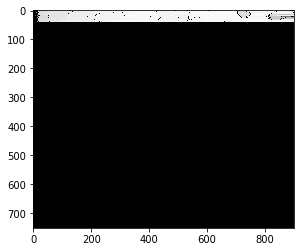


Scanline : 41 / 750
1801 / 1801
Scanline : 42 / 750
1801 / 1801
Scanline : 43 / 750
1801 / 1801
Scanline : 44 / 750
1801 / 1801
Scanline : 45 / 750
1801 / 1801
Scanline : 46 / 750
1801 / 1801
Scanline : 47 / 750
1801 / 1801
Scanline : 48 / 750
1801 / 1801
Scanline : 49 / 750
1801 / 1801
Scanline : 50 / 750
1801 / 1801
Scanline : 51 / 750
1801 / 1801
Scanline : 52 / 750
1801 / 1801
Scanline : 53 / 750
1801 / 1801
Scanline : 54 / 750
1801 / 1801
Scanline : 55 / 750
1801 / 1801
Scanline : 56 / 750
1801 / 1801
Scanline : 57 / 750
1801 / 1801
Scanline : 58 / 750
1801 / 1801
Scanline : 59 / 750
1801 / 1801
Scanline : 60 / 750
1801 / 1801

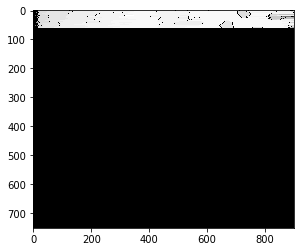


Scanline : 61 / 750
1801 / 1801
Scanline : 62 / 750
1801 / 1801
Scanline : 63 / 750
1801 / 1801
Scanline : 64 / 750
1801 / 1801
Scanline : 65 / 750
1801 / 1801
Scanline : 66 / 750
1801 / 1801
Scanline : 67 / 750
1801 / 1801
Scanline : 68 / 750
1801 / 1801
Scanline : 69 / 750
1801 / 1801
Scanline : 70 / 750
1801 / 1801
Scanline : 71 / 750
1801 / 1801
Scanline : 72 / 750
1801 / 1801
Scanline : 73 / 750
1801 / 1801
Scanline : 74 / 750
1801 / 1801
Scanline : 75 / 750
1801 / 1801
Scanline : 76 / 750
1801 / 1801
Scanline : 77 / 750
1801 / 1801
Scanline : 78 / 750
1801 / 1801
Scanline : 79 / 750
1801 / 1801
Scanline : 80 / 750
1801 / 1801

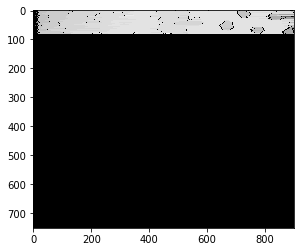


Scanline : 81 / 750
1801 / 1801
Scanline : 82 / 750
1801 / 1801
Scanline : 83 / 750
1801 / 1801
Scanline : 84 / 750
1801 / 1801
Scanline : 85 / 750
1801 / 1801
Scanline : 86 / 750
1801 / 1801
Scanline : 87 / 750
1801 / 1801
Scanline : 88 / 750
1801 / 1801
Scanline : 89 / 750
1801 / 1801
Scanline : 90 / 750
1801 / 1801
Scanline : 91 / 750
1801 / 1801
Scanline : 92 / 750
1801 / 1801
Scanline : 93 / 750
1801 / 1801
Scanline : 94 / 750
1801 / 1801
Scanline : 95 / 750
1801 / 1801
Scanline : 96 / 750
1801 / 1801
Scanline : 97 / 750
1801 / 1801
Scanline : 98 / 750
1801 / 1801
Scanline : 99 / 750
1801 / 1801
Scanline : 100 / 750
1801 / 1801

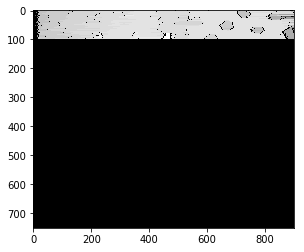


Scanline : 101 / 750
1801 / 1801
Scanline : 102 / 750
1801 / 1801
Scanline : 103 / 750
1801 / 1801
Scanline : 104 / 750
1801 / 1801
Scanline : 105 / 750
1801 / 1801
Scanline : 106 / 750
1801 / 1801
Scanline : 107 / 750
1801 / 1801
Scanline : 108 / 750
1801 / 1801
Scanline : 109 / 750
1801 / 1801
Scanline : 110 / 750
1801 / 1801
Scanline : 111 / 750
1801 / 1801
Scanline : 112 / 750
1801 / 1801
Scanline : 113 / 750
1801 / 1801
Scanline : 114 / 750
1801 / 1801
Scanline : 115 / 750
1801 / 1801
Scanline : 116 / 750
1801 / 1801
Scanline : 117 / 750
1801 / 1801
Scanline : 118 / 750
1801 / 1801
Scanline : 119 / 750
1801 / 1801
Scanline : 120 / 750
1801 / 1801

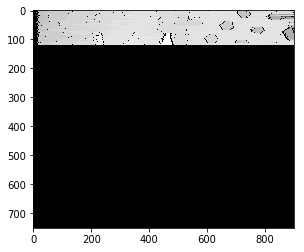


Scanline : 121 / 750
1801 / 1801
Scanline : 122 / 750
1801 / 1801
Scanline : 123 / 750
1801 / 1801
Scanline : 124 / 750
1801 / 1801
Scanline : 125 / 750
1801 / 1801
Scanline : 126 / 750
1801 / 1801
Scanline : 127 / 750
1801 / 1801
Scanline : 128 / 750
1801 / 1801
Scanline : 129 / 750
1801 / 1801
Scanline : 130 / 750
1801 / 1801
Scanline : 131 / 750
1801 / 1801
Scanline : 132 / 750
1801 / 1801
Scanline : 133 / 750
1801 / 1801
Scanline : 134 / 750
1801 / 1801
Scanline : 135 / 750
1801 / 1801
Scanline : 136 / 750
1801 / 1801
Scanline : 137 / 750
1801 / 1801
Scanline : 138 / 750
1801 / 1801
Scanline : 139 / 750
1801 / 1801
Scanline : 140 / 750
1801 / 1801

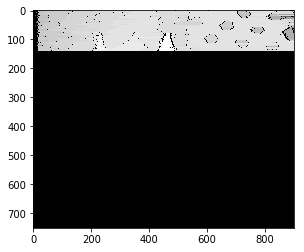


Scanline : 141 / 750
1801 / 1801
Scanline : 142 / 750
1801 / 1801
Scanline : 143 / 750
1801 / 1801
Scanline : 144 / 750
1801 / 1801
Scanline : 145 / 750
1801 / 1801
Scanline : 146 / 750
1801 / 1801
Scanline : 147 / 750
1801 / 1801
Scanline : 148 / 750
1801 / 1801
Scanline : 149 / 750
1801 / 1801
Scanline : 150 / 750
1801 / 1801
Scanline : 151 / 750
1801 / 1801
Scanline : 152 / 750
1801 / 1801
Scanline : 153 / 750
1801 / 1801
Scanline : 154 / 750
1801 / 1801
Scanline : 155 / 750
1801 / 1801
Scanline : 156 / 750
1801 / 1801
Scanline : 157 / 750
1801 / 1801
Scanline : 158 / 750
1801 / 1801
Scanline : 159 / 750
1801 / 1801
Scanline : 160 / 750
1801 / 1801

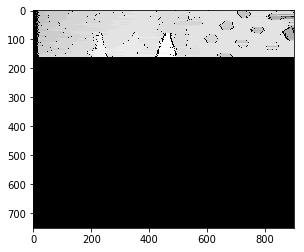


Scanline : 161 / 750
1801 / 1801
Scanline : 162 / 750
1801 / 1801
Scanline : 163 / 750
1801 / 1801
Scanline : 164 / 750
1801 / 1801
Scanline : 165 / 750
1801 / 1801
Scanline : 166 / 750
1801 / 1801
Scanline : 167 / 750
1801 / 1801
Scanline : 168 / 750
1801 / 1801
Scanline : 169 / 750
1801 / 1801
Scanline : 170 / 750
1801 / 1801
Scanline : 171 / 750
1801 / 1801
Scanline : 172 / 750
1801 / 1801
Scanline : 173 / 750
1801 / 1801
Scanline : 174 / 750
1801 / 1801
Scanline : 175 / 750
1801 / 1801
Scanline : 176 / 750
1801 / 1801
Scanline : 177 / 750
1801 / 1801
Scanline : 178 / 750
1801 / 1801
Scanline : 179 / 750
1801 / 1801
Scanline : 180 / 750
1801 / 1801

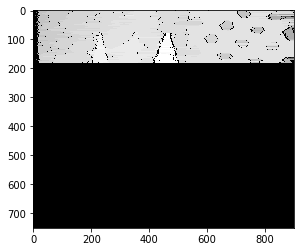


Scanline : 181 / 750
1801 / 1801
Scanline : 182 / 750
1801 / 1801
Scanline : 183 / 750
1801 / 1801
Scanline : 184 / 750
1801 / 1801
Scanline : 185 / 750
1801 / 1801
Scanline : 186 / 750
1801 / 1801
Scanline : 187 / 750
1801 / 1801
Scanline : 188 / 750
1801 / 1801
Scanline : 189 / 750
1801 / 1801
Scanline : 190 / 750
1801 / 1801
Scanline : 191 / 750
1801 / 1801
Scanline : 192 / 750
1801 / 1801
Scanline : 193 / 750
1801 / 1801
Scanline : 194 / 750
1801 / 1801
Scanline : 195 / 750
1801 / 1801
Scanline : 196 / 750
1801 / 1801
Scanline : 197 / 750
1801 / 1801
Scanline : 198 / 750
1801 / 1801
Scanline : 199 / 750
1801 / 1801
Scanline : 200 / 750
1801 / 1801

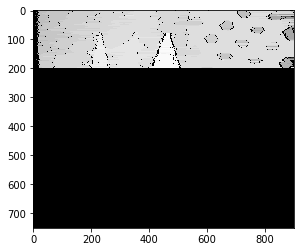


Scanline : 201 / 750
1801 / 1801
Scanline : 202 / 750
1801 / 1801
Scanline : 203 / 750
1801 / 1801
Scanline : 204 / 750
1801 / 1801
Scanline : 205 / 750
1801 / 1801
Scanline : 206 / 750
1801 / 1801
Scanline : 207 / 750
1801 / 1801
Scanline : 208 / 750
1801 / 1801
Scanline : 209 / 750
1801 / 1801
Scanline : 210 / 750
1801 / 1801
Scanline : 211 / 750
1801 / 1801
Scanline : 212 / 750
1801 / 1801
Scanline : 213 / 750
1801 / 1801
Scanline : 214 / 750
1801 / 1801
Scanline : 215 / 750
1801 / 1801
Scanline : 216 / 750
1801 / 1801
Scanline : 217 / 750
1801 / 1801
Scanline : 218 / 750
1801 / 1801
Scanline : 219 / 750
1801 / 1801
Scanline : 220 / 750
1801 / 1801

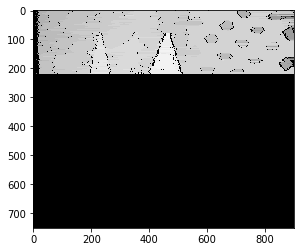


Scanline : 221 / 750
1801 / 1801
Scanline : 222 / 750
1801 / 1801
Scanline : 223 / 750
1801 / 1801
Scanline : 224 / 750
1801 / 1801
Scanline : 225 / 750
1801 / 1801
Scanline : 226 / 750
1801 / 1801
Scanline : 227 / 750
1801 / 1801
Scanline : 228 / 750
1801 / 1801
Scanline : 229 / 750
1801 / 1801
Scanline : 230 / 750
1801 / 1801
Scanline : 231 / 750
1801 / 1801
Scanline : 232 / 750
1801 / 1801
Scanline : 233 / 750
1801 / 1801
Scanline : 234 / 750
1801 / 1801
Scanline : 235 / 750
1801 / 1801
Scanline : 236 / 750
1801 / 1801
Scanline : 237 / 750
1801 / 1801
Scanline : 238 / 750
1801 / 1801
Scanline : 239 / 750
1801 / 1801
Scanline : 240 / 750
1801 / 1801

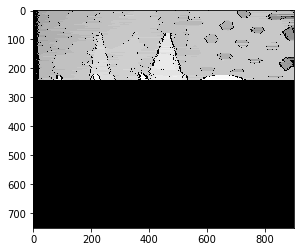


Scanline : 241 / 750
1801 / 1801
Scanline : 242 / 750
1801 / 1801
Scanline : 243 / 750
1801 / 1801
Scanline : 244 / 750
1801 / 1801
Scanline : 245 / 750
1801 / 1801
Scanline : 246 / 750
1801 / 1801
Scanline : 247 / 750
1801 / 1801
Scanline : 248 / 750
1801 / 1801
Scanline : 249 / 750
1801 / 1801
Scanline : 250 / 750
1801 / 1801
Scanline : 251 / 750
1801 / 1801
Scanline : 252 / 750
1801 / 1801
Scanline : 253 / 750
1801 / 1801
Scanline : 254 / 750
1801 / 1801
Scanline : 255 / 750
1801 / 1801
Scanline : 256 / 750
1801 / 1801
Scanline : 257 / 750
1801 / 1801
Scanline : 258 / 750
1801 / 1801
Scanline : 259 / 750
1801 / 1801
Scanline : 260 / 750
1801 / 1801

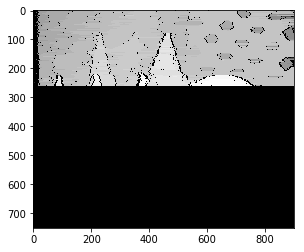


Scanline : 261 / 750
1801 / 1801
Scanline : 262 / 750
1801 / 1801
Scanline : 263 / 750
1801 / 1801
Scanline : 264 / 750
1801 / 1801
Scanline : 265 / 750
1801 / 1801
Scanline : 266 / 750
1801 / 1801
Scanline : 267 / 750
1801 / 1801
Scanline : 268 / 750
1801 / 1801
Scanline : 269 / 750
1801 / 1801
Scanline : 270 / 750
1801 / 1801
Scanline : 271 / 750
1801 / 1801
Scanline : 272 / 750
1801 / 1801
Scanline : 273 / 750
1801 / 1801
Scanline : 274 / 750
1801 / 1801
Scanline : 275 / 750
1801 / 1801
Scanline : 276 / 750
1801 / 1801
Scanline : 277 / 750
1801 / 1801
Scanline : 278 / 750
1801 / 1801
Scanline : 279 / 750
1801 / 1801
Scanline : 280 / 750
1801 / 1801

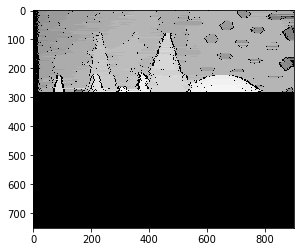


Scanline : 281 / 750
1801 / 1801
Scanline : 282 / 750
1801 / 1801
Scanline : 283 / 750
1801 / 1801
Scanline : 284 / 750
1801 / 1801
Scanline : 285 / 750
1801 / 1801
Scanline : 286 / 750
1801 / 1801
Scanline : 287 / 750
1801 / 1801
Scanline : 288 / 750
1801 / 1801
Scanline : 289 / 750
1801 / 1801
Scanline : 290 / 750
1801 / 1801
Scanline : 291 / 750
1801 / 1801
Scanline : 292 / 750
1801 / 1801
Scanline : 293 / 750
1801 / 1801
Scanline : 294 / 750
1801 / 1801
Scanline : 295 / 750
1801 / 1801
Scanline : 296 / 750
1801 / 1801
Scanline : 297 / 750
1801 / 1801
Scanline : 298 / 750
1801 / 1801
Scanline : 299 / 750
1801 / 1801
Scanline : 300 / 750
1801 / 1801

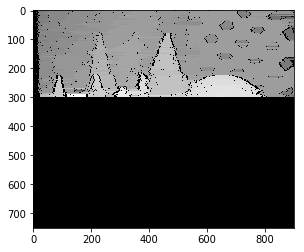


Scanline : 301 / 750
1801 / 1801
Scanline : 302 / 750
1801 / 1801
Scanline : 303 / 750
1801 / 1801
Scanline : 304 / 750
1801 / 1801
Scanline : 305 / 750
1801 / 1801
Scanline : 306 / 750
1801 / 1801
Scanline : 307 / 750
1801 / 1801
Scanline : 308 / 750
1801 / 1801
Scanline : 309 / 750
1801 / 1801
Scanline : 310 / 750
1801 / 1801
Scanline : 311 / 750
1801 / 1801
Scanline : 312 / 750
1801 / 1801
Scanline : 313 / 750
1801 / 1801
Scanline : 314 / 750
1801 / 1801
Scanline : 315 / 750
1801 / 1801
Scanline : 316 / 750
1801 / 1801
Scanline : 317 / 750
1801 / 1801
Scanline : 318 / 750
1801 / 1801
Scanline : 319 / 750
1801 / 1801
Scanline : 320 / 750
1801 / 1801

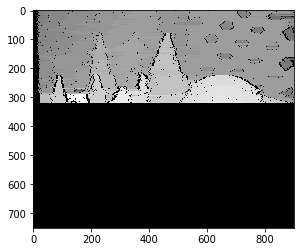


Scanline : 321 / 750
1801 / 1801
Scanline : 322 / 750
1801 / 1801
Scanline : 323 / 750
1801 / 1801
Scanline : 324 / 750
1801 / 1801
Scanline : 325 / 750
1801 / 1801
Scanline : 326 / 750
1801 / 1801
Scanline : 327 / 750
1801 / 1801
Scanline : 328 / 750
1801 / 1801
Scanline : 329 / 750
1801 / 1801
Scanline : 330 / 750
1801 / 1801
Scanline : 331 / 750
1801 / 1801
Scanline : 332 / 750
1801 / 1801
Scanline : 333 / 750
1801 / 1801
Scanline : 334 / 750
1801 / 1801
Scanline : 335 / 750
1801 / 1801
Scanline : 336 / 750
1801 / 1801
Scanline : 337 / 750
1801 / 1801
Scanline : 338 / 750
1801 / 1801
Scanline : 339 / 750
1801 / 1801
Scanline : 340 / 750
1801 / 1801

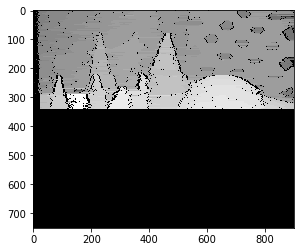


Scanline : 341 / 750
1801 / 1801
Scanline : 342 / 750
1801 / 1801
Scanline : 343 / 750
1801 / 1801
Scanline : 344 / 750
1801 / 1801
Scanline : 345 / 750
1801 / 1801
Scanline : 346 / 750
1801 / 1801
Scanline : 347 / 750
1801 / 1801
Scanline : 348 / 750
1801 / 1801
Scanline : 349 / 750
1801 / 1801
Scanline : 350 / 750
1801 / 1801
Scanline : 351 / 750
1801 / 1801
Scanline : 352 / 750
1801 / 1801
Scanline : 353 / 750
1801 / 1801
Scanline : 354 / 750
1801 / 1801
Scanline : 355 / 750
1801 / 1801
Scanline : 356 / 750
1801 / 1801
Scanline : 357 / 750
1801 / 1801
Scanline : 358 / 750
1801 / 1801
Scanline : 359 / 750
1801 / 1801
Scanline : 360 / 750
1801 / 1801

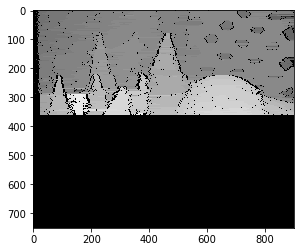


Scanline : 361 / 750
1801 / 1801
Scanline : 362 / 750
1801 / 1801
Scanline : 363 / 750
1801 / 1801
Scanline : 364 / 750
1801 / 1801
Scanline : 365 / 750
1801 / 1801
Scanline : 366 / 750
1801 / 1801
Scanline : 367 / 750
1801 / 1801
Scanline : 368 / 750
1801 / 1801
Scanline : 369 / 750
1801 / 1801
Scanline : 370 / 750
1801 / 1801
Scanline : 371 / 750
1801 / 1801
Scanline : 372 / 750
1801 / 1801
Scanline : 373 / 750
1801 / 1801
Scanline : 374 / 750
1801 / 1801
Scanline : 375 / 750
1801 / 1801
Scanline : 376 / 750
1801 / 1801
Scanline : 377 / 750
1801 / 1801
Scanline : 378 / 750
1801 / 1801
Scanline : 379 / 750
1801 / 1801
Scanline : 380 / 750
1801 / 1801

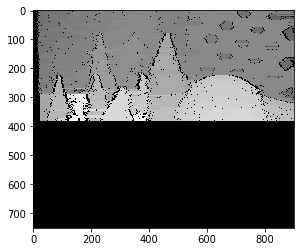


Scanline : 381 / 750
1801 / 1801
Scanline : 382 / 750
1801 / 1801
Scanline : 383 / 750
1801 / 1801
Scanline : 384 / 750
1801 / 1801
Scanline : 385 / 750
1801 / 1801
Scanline : 386 / 750
1801 / 1801
Scanline : 387 / 750
1801 / 1801
Scanline : 388 / 750
1801 / 1801
Scanline : 389 / 750
1801 / 1801
Scanline : 390 / 750
1801 / 1801
Scanline : 391 / 750
1801 / 1801
Scanline : 392 / 750
1801 / 1801
Scanline : 393 / 750
1801 / 1801
Scanline : 394 / 750
1801 / 1801
Scanline : 395 / 750
1801 / 1801
Scanline : 396 / 750
1801 / 1801
Scanline : 397 / 750
1801 / 1801
Scanline : 398 / 750
1801 / 1801
Scanline : 399 / 750
1801 / 1801
Scanline : 400 / 750
1801 / 1801

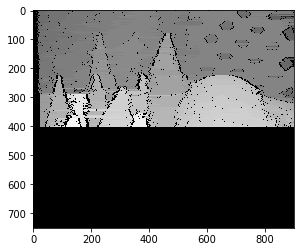


Scanline : 401 / 750
1801 / 1801
Scanline : 402 / 750
1801 / 1801
Scanline : 403 / 750
1801 / 1801
Scanline : 404 / 750
1801 / 1801
Scanline : 405 / 750
1801 / 1801
Scanline : 406 / 750
1801 / 1801
Scanline : 407 / 750
1801 / 1801
Scanline : 408 / 750
1801 / 1801
Scanline : 409 / 750
1801 / 1801
Scanline : 410 / 750
1801 / 1801
Scanline : 411 / 750
1801 / 1801
Scanline : 412 / 750
1801 / 1801
Scanline : 413 / 750
1801 / 1801
Scanline : 414 / 750
1801 / 1801
Scanline : 415 / 750
1801 / 1801
Scanline : 416 / 750
1801 / 1801
Scanline : 417 / 750
1801 / 1801
Scanline : 418 / 750
1801 / 1801
Scanline : 419 / 750
1801 / 1801
Scanline : 420 / 750
1801 / 1801

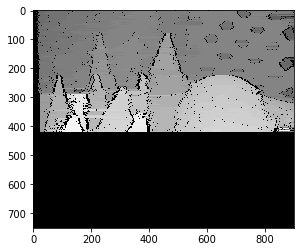


Scanline : 421 / 750
1801 / 1801
Scanline : 422 / 750
1801 / 1801
Scanline : 423 / 750
1801 / 1801
Scanline : 424 / 750
1801 / 1801
Scanline : 425 / 750
1801 / 1801
Scanline : 426 / 750
1801 / 1801
Scanline : 427 / 750
1801 / 1801
Scanline : 428 / 750
1801 / 1801
Scanline : 429 / 750
1801 / 1801
Scanline : 430 / 750
1801 / 1801
Scanline : 431 / 750
1801 / 1801
Scanline : 432 / 750
1801 / 1801
Scanline : 433 / 750
1801 / 1801
Scanline : 434 / 750
1801 / 1801
Scanline : 435 / 750
1801 / 1801
Scanline : 436 / 750
1801 / 1801
Scanline : 437 / 750
1801 / 1801
Scanline : 438 / 750
1801 / 1801
Scanline : 439 / 750
1801 / 1801
Scanline : 440 / 750
1801 / 1801

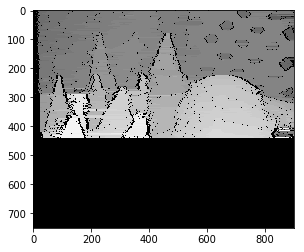


Scanline : 441 / 750
1801 / 1801
Scanline : 442 / 750
1801 / 1801
Scanline : 443 / 750
1801 / 1801
Scanline : 444 / 750
1801 / 1801
Scanline : 445 / 750
1801 / 1801
Scanline : 446 / 750
1801 / 1801
Scanline : 447 / 750
1801 / 1801
Scanline : 448 / 750
1801 / 1801
Scanline : 449 / 750
1801 / 1801
Scanline : 450 / 750
1801 / 1801
Scanline : 451 / 750
1801 / 1801
Scanline : 452 / 750
1801 / 1801
Scanline : 453 / 750
1801 / 1801
Scanline : 454 / 750
1801 / 1801
Scanline : 455 / 750
1801 / 1801
Scanline : 456 / 750
1801 / 1801
Scanline : 457 / 750
1801 / 1801
Scanline : 458 / 750
1801 / 1801
Scanline : 459 / 750
1801 / 1801
Scanline : 460 / 750
1801 / 1801

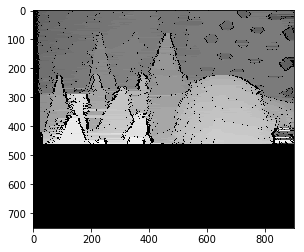


Scanline : 461 / 750
1801 / 1801
Scanline : 462 / 750
1801 / 1801
Scanline : 463 / 750
1801 / 1801
Scanline : 464 / 750
1801 / 1801
Scanline : 465 / 750
1801 / 1801
Scanline : 466 / 750
1801 / 1801
Scanline : 467 / 750
1801 / 1801
Scanline : 468 / 750
1801 / 1801
Scanline : 469 / 750
1801 / 1801
Scanline : 470 / 750
1801 / 1801
Scanline : 471 / 750
1801 / 1801
Scanline : 472 / 750
1801 / 1801
Scanline : 473 / 750
1801 / 1801
Scanline : 474 / 750
1801 / 1801
Scanline : 475 / 750
1801 / 1801
Scanline : 476 / 750
1801 / 1801
Scanline : 477 / 750
1801 / 1801
Scanline : 478 / 750
1801 / 1801
Scanline : 479 / 750
1801 / 1801
Scanline : 480 / 750
1801 / 1801

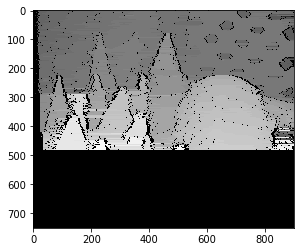


Scanline : 481 / 750
1801 / 1801
Scanline : 482 / 750
1801 / 1801
Scanline : 483 / 750
1801 / 1801
Scanline : 484 / 750
1801 / 1801
Scanline : 485 / 750
1801 / 1801
Scanline : 486 / 750
1801 / 1801
Scanline : 487 / 750
1801 / 1801
Scanline : 488 / 750
1801 / 1801
Scanline : 489 / 750
1801 / 1801
Scanline : 490 / 750
1801 / 1801
Scanline : 491 / 750
1801 / 1801
Scanline : 492 / 750
1801 / 1801
Scanline : 493 / 750
1801 / 1801
Scanline : 494 / 750
1801 / 1801
Scanline : 495 / 750
1801 / 1801
Scanline : 496 / 750
1801 / 1801
Scanline : 497 / 750
1801 / 1801
Scanline : 498 / 750
1801 / 1801
Scanline : 499 / 750
1801 / 1801
Scanline : 500 / 750
1801 / 1801

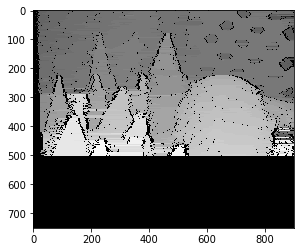


Scanline : 501 / 750
1801 / 1801
Scanline : 502 / 750
1801 / 1801
Scanline : 503 / 750
1801 / 1801
Scanline : 504 / 750
1801 / 1801
Scanline : 505 / 750
1801 / 1801
Scanline : 506 / 750
1801 / 1801
Scanline : 507 / 750
1801 / 1801
Scanline : 508 / 750
1801 / 1801
Scanline : 509 / 750
1801 / 1801
Scanline : 510 / 750
1801 / 1801
Scanline : 511 / 750
1801 / 1801
Scanline : 512 / 750
1801 / 1801
Scanline : 513 / 750
1801 / 1801
Scanline : 514 / 750
1801 / 1801
Scanline : 515 / 750
1801 / 1801
Scanline : 516 / 750
1801 / 1801
Scanline : 517 / 750
1801 / 1801
Scanline : 518 / 750
1801 / 1801
Scanline : 519 / 750
1801 / 1801
Scanline : 520 / 750
1801 / 1801

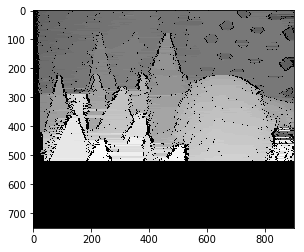


Scanline : 521 / 750
1801 / 1801
Scanline : 522 / 750
1801 / 1801
Scanline : 523 / 750
1801 / 1801
Scanline : 524 / 750
1801 / 1801
Scanline : 525 / 750
1801 / 1801
Scanline : 526 / 750
1801 / 1801
Scanline : 527 / 750
1801 / 1801
Scanline : 528 / 750
1801 / 1801
Scanline : 529 / 750
1801 / 1801
Scanline : 530 / 750
1801 / 1801
Scanline : 531 / 750
1801 / 1801
Scanline : 532 / 750
1801 / 1801
Scanline : 533 / 750
1801 / 1801
Scanline : 534 / 750
1801 / 1801
Scanline : 535 / 750
1801 / 1801
Scanline : 536 / 750
1801 / 1801
Scanline : 537 / 750
1801 / 1801
Scanline : 538 / 750
1801 / 1801
Scanline : 539 / 750
1801 / 1801
Scanline : 540 / 750
1801 / 1801

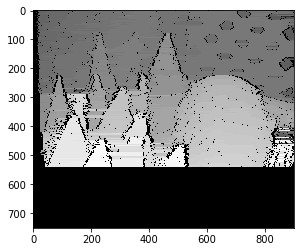


Scanline : 541 / 750
1801 / 1801
Scanline : 542 / 750
1801 / 1801
Scanline : 543 / 750
1801 / 1801
Scanline : 544 / 750
1801 / 1801
Scanline : 545 / 750
1801 / 1801
Scanline : 546 / 750
1801 / 1801
Scanline : 547 / 750
1801 / 1801
Scanline : 548 / 750
1801 / 1801
Scanline : 549 / 750
1801 / 1801
Scanline : 550 / 750
1801 / 1801
Scanline : 551 / 750
1801 / 1801
Scanline : 552 / 750
1801 / 1801
Scanline : 553 / 750
1801 / 1801
Scanline : 554 / 750
1801 / 1801
Scanline : 555 / 750
1801 / 1801
Scanline : 556 / 750
1801 / 1801
Scanline : 557 / 750
1801 / 1801
Scanline : 558 / 750
1801 / 1801
Scanline : 559 / 750
1801 / 1801
Scanline : 560 / 750
1801 / 1801

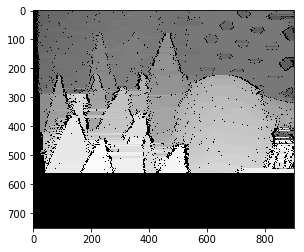


Scanline : 561 / 750
1801 / 1801
Scanline : 562 / 750
1801 / 1801
Scanline : 563 / 750
1801 / 1801
Scanline : 564 / 750
1801 / 1801
Scanline : 565 / 750
1801 / 1801
Scanline : 566 / 750
1801 / 1801
Scanline : 567 / 750
1801 / 1801
Scanline : 568 / 750
1801 / 1801
Scanline : 569 / 750
1801 / 1801
Scanline : 570 / 750
1801 / 1801
Scanline : 571 / 750
1801 / 1801
Scanline : 572 / 750
1801 / 1801
Scanline : 573 / 750
1801 / 1801
Scanline : 574 / 750
1801 / 1801
Scanline : 575 / 750
1801 / 1801
Scanline : 576 / 750
1801 / 1801
Scanline : 577 / 750
1801 / 1801
Scanline : 578 / 750
1801 / 1801
Scanline : 579 / 750
1801 / 1801
Scanline : 580 / 750
1801 / 1801

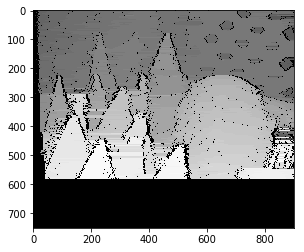


Scanline : 581 / 750
1801 / 1801
Scanline : 582 / 750
1801 / 1801
Scanline : 583 / 750
1801 / 1801
Scanline : 584 / 750
1801 / 1801
Scanline : 585 / 750
1801 / 1801
Scanline : 586 / 750
1801 / 1801
Scanline : 587 / 750
1801 / 1801
Scanline : 588 / 750
1801 / 1801
Scanline : 589 / 750
1801 / 1801
Scanline : 590 / 750
1801 / 1801
Scanline : 591 / 750
1801 / 1801
Scanline : 592 / 750
1801 / 1801
Scanline : 593 / 750
1801 / 1801
Scanline : 594 / 750
1801 / 1801
Scanline : 595 / 750
1801 / 1801
Scanline : 596 / 750
1801 / 1801
Scanline : 597 / 750
1801 / 1801
Scanline : 598 / 750
1801 / 1801
Scanline : 599 / 750
1801 / 1801
Scanline : 600 / 750
1801 / 1801

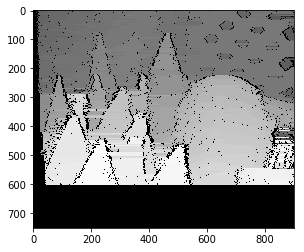


Scanline : 601 / 750
1801 / 1801
Scanline : 602 / 750
1801 / 1801
Scanline : 603 / 750
1801 / 1801
Scanline : 604 / 750
1801 / 1801
Scanline : 605 / 750
1801 / 1801
Scanline : 606 / 750
1801 / 1801
Scanline : 607 / 750
1801 / 1801
Scanline : 608 / 750
1801 / 1801
Scanline : 609 / 750
1801 / 1801
Scanline : 610 / 750
1801 / 1801
Scanline : 611 / 750
1801 / 1801
Scanline : 612 / 750
1801 / 1801
Scanline : 613 / 750
1801 / 1801
Scanline : 614 / 750
1801 / 1801
Scanline : 615 / 750
1801 / 1801
Scanline : 616 / 750
1801 / 1801
Scanline : 617 / 750
1801 / 1801
Scanline : 618 / 750
1801 / 1801
Scanline : 619 / 750
1801 / 1801
Scanline : 620 / 750
1801 / 1801

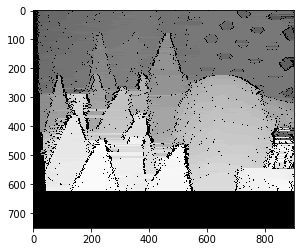


Scanline : 621 / 750
1801 / 1801
Scanline : 622 / 750
1801 / 1801
Scanline : 623 / 750
1801 / 1801
Scanline : 624 / 750
1801 / 1801
Scanline : 625 / 750
1801 / 1801
Scanline : 626 / 750
1801 / 1801
Scanline : 627 / 750
1801 / 1801
Scanline : 628 / 750
1801 / 1801
Scanline : 629 / 750
1801 / 1801
Scanline : 630 / 750
1801 / 1801
Scanline : 631 / 750
1801 / 1801
Scanline : 632 / 750
1801 / 1801
Scanline : 633 / 750
1801 / 1801
Scanline : 634 / 750
1801 / 1801
Scanline : 635 / 750
1801 / 1801
Scanline : 636 / 750
1801 / 1801
Scanline : 637 / 750
1801 / 1801
Scanline : 638 / 750
1801 / 1801
Scanline : 639 / 750
1801 / 1801
Scanline : 640 / 750
1801 / 1801

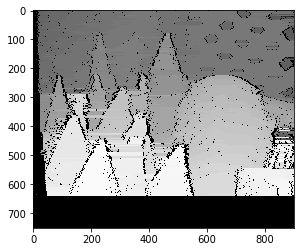


Scanline : 641 / 750
1801 / 1801
Scanline : 642 / 750
1801 / 1801
Scanline : 643 / 750
1801 / 1801
Scanline : 644 / 750
1801 / 1801
Scanline : 645 / 750
1801 / 1801
Scanline : 646 / 750
1801 / 1801
Scanline : 647 / 750
1801 / 1801
Scanline : 648 / 750
1801 / 1801
Scanline : 649 / 750
1801 / 1801
Scanline : 650 / 750
1801 / 1801
Scanline : 651 / 750
1801 / 1801
Scanline : 652 / 750
1801 / 1801
Scanline : 653 / 750
1801 / 1801
Scanline : 654 / 750
1801 / 1801
Scanline : 655 / 750
1801 / 1801
Scanline : 656 / 750
1801 / 1801
Scanline : 657 / 750
1801 / 1801
Scanline : 658 / 750
1801 / 1801
Scanline : 659 / 750
1801 / 1801
Scanline : 660 / 750
1801 / 1801

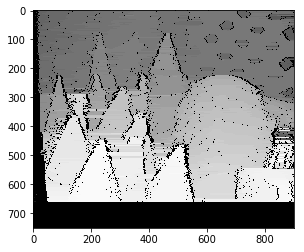


Scanline : 661 / 750
1801 / 1801
Scanline : 662 / 750
1801 / 1801
Scanline : 663 / 750
1801 / 1801
Scanline : 664 / 750
1801 / 1801
Scanline : 665 / 750
1801 / 1801
Scanline : 666 / 750
1801 / 1801
Scanline : 667 / 750
1801 / 1801
Scanline : 668 / 750
1801 / 1801
Scanline : 669 / 750
1801 / 1801
Scanline : 670 / 750
1801 / 1801
Scanline : 671 / 750
1801 / 1801
Scanline : 672 / 750
1801 / 1801
Scanline : 673 / 750
1801 / 1801
Scanline : 674 / 750
1801 / 1801
Scanline : 675 / 750
1801 / 1801
Scanline : 676 / 750
1801 / 1801
Scanline : 677 / 750
1801 / 1801
Scanline : 678 / 750
1801 / 1801
Scanline : 679 / 750
1801 / 1801
Scanline : 680 / 750
1801 / 1801

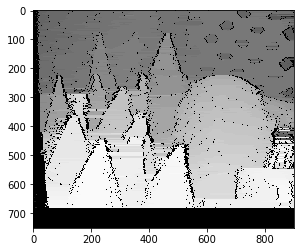


Scanline : 681 / 750
1801 / 1801
Scanline : 682 / 750
1801 / 1801
Scanline : 683 / 750
1801 / 1801
Scanline : 684 / 750
1801 / 1801
Scanline : 685 / 750
1801 / 1801
Scanline : 686 / 750
1801 / 1801
Scanline : 687 / 750
1801 / 1801
Scanline : 688 / 750
1801 / 1801
Scanline : 689 / 750
1801 / 1801
Scanline : 690 / 750
1801 / 1801
Scanline : 691 / 750
1801 / 1801
Scanline : 692 / 750
1801 / 1801
Scanline : 693 / 750
1801 / 1801
Scanline : 694 / 750
1801 / 1801
Scanline : 695 / 750
1801 / 1801
Scanline : 696 / 750
1801 / 1801
Scanline : 697 / 750
1801 / 1801
Scanline : 698 / 750
1801 / 1801
Scanline : 699 / 750
1801 / 1801
Scanline : 700 / 750
1801 / 1801

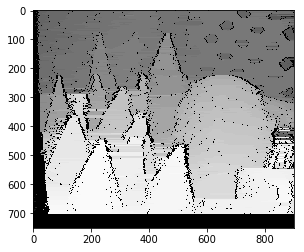


Scanline : 701 / 750
1801 / 1801
Scanline : 702 / 750
1801 / 1801
Scanline : 703 / 750
1801 / 1801
Scanline : 704 / 750
1801 / 1801
Scanline : 705 / 750
1801 / 1801
Scanline : 706 / 750
1801 / 1801
Scanline : 707 / 750
1801 / 1801
Scanline : 708 / 750
1801 / 1801
Scanline : 709 / 750
1801 / 1801
Scanline : 710 / 750
1801 / 1801
Scanline : 711 / 750
1801 / 1801
Scanline : 712 / 750
1801 / 1801
Scanline : 713 / 750
1801 / 1801
Scanline : 714 / 750
1801 / 1801
Scanline : 715 / 750
1801 / 1801
Scanline : 716 / 750
1801 / 1801
Scanline : 717 / 750
1801 / 1801
Scanline : 718 / 750
1801 / 1801
Scanline : 719 / 750
1801 / 1801
Scanline : 720 / 750
1801 / 1801

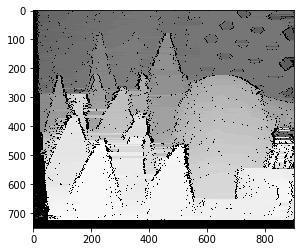


Scanline : 721 / 750
1801 / 1801
Scanline : 722 / 750
1801 / 1801
Scanline : 723 / 750
1801 / 1801
Scanline : 724 / 750
1801 / 1801
Scanline : 725 / 750
1801 / 1801
Scanline : 726 / 750
1801 / 1801
Scanline : 727 / 750
1801 / 1801
Scanline : 728 / 750
1801 / 1801
Scanline : 729 / 750
1801 / 1801
Scanline : 730 / 750
1801 / 1801
Scanline : 731 / 750
1801 / 1801
Scanline : 732 / 750
1801 / 1801
Scanline : 733 / 750
1801 / 1801
Scanline : 734 / 750
1801 / 1801
Scanline : 735 / 750
1801 / 1801
Scanline : 736 / 750
1801 / 1801
Scanline : 737 / 750
1801 / 1801
Scanline : 738 / 750
1801 / 1801
Scanline : 739 / 750
1801 / 1801
Scanline : 740 / 750
1801 / 1801

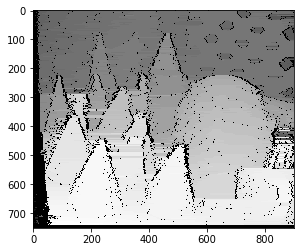


Scanline : 741 / 750
1801 / 1801
Scanline : 742 / 750
1801 / 1801
Scanline : 743 / 750
1801 / 1801
Scanline : 744 / 750
1801 / 1801
Scanline : 745 / 750
1801 / 1801
Scanline : 746 / 750
1801 / 1801
Scanline : 747 / 750
1801 / 1801
Scanline : 748 / 750
1801 / 1801
Scanline : 749 / 750
1801 / 1801

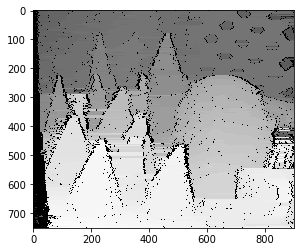

Time taken : 2622.16242909 secs


In [0]:

numberScanLine = numpyLeftImg.shape[0]#reshapeSize[1]
#lenSequence = reshapeSize[0] + 1
lenSequence = 900
lenSequence += 1


print("I BEGIN TO LOAD")
cumul_nb_cells_computed = cp.load("./2D_lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./2D_lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

#pos_in_seq1 = cp.full((lenSequence**2, ), -1)
#pos_in_seq1 += position_in_nw_flatten_matrix // (lenSequence+1)

#pos_in_seq2 = cp.full((lenSequence**2, ), -1)
#pos_in_seq2 += position_in_nw_flatten_matrix % (lenSequence+1)

#pos_in_seq1 = cp.full((lenSequence**2, ), -1)
pos_in_seq1 = cp.asarray(position_in_nw_flatten_matrix // (lenSequence+1) - 1)

#pos_in_seq2 = cp.full((lenSequence**2, ), -1)
pos_in_seq2 = cp.asarray(position_in_nw_flatten_matrix % (lenSequence+1) - 1)

print("FINISH TO LOAD")




disparityMap = np.zeros((numberScanLine, lenSequence-1))

begin_compute = time.time()
for k in range(numberScanLine):
  print("\nScanline : {} / {}".format(k, numberScanLine))
  scanlineChoosen = k
  seq1 = numpyLeftImg[scanlineChoosen, :]
  seq2 = numpyRightImg[scanlineChoosen, :]
  sequenceNumber1 = seq1
  sequenceNumber2 = seq2



  u1 = cp.empty((lenSequence, ), dtype=cp.int32)
  u1[0] = 0 #-256*2-1
  u1[1:] = cp.array(seq1)

  u2 = cp.empty((lenSequence, ), dtype=cp.int32)
  u2[0] = 0 # -256*3-1
  u2[1:] = cp.array(seq2)

  
  scoreMatrix, tempsPasseAtEachStep, G, H = computeScoringMatrix(u1, u2)

  path = determinatePath(cp.asnumpy(scoreMatrix), cp.asnumpy(G), cp.asnumpy(H))
  S1final, S2final = alignSequences(seq1, seq2, path)
  
  DisparityMapS1 = []
  DisparityMapS2 = []
  
  """
 # print the align sequences:
  for i in range(len(S1final)):
    if (S1final[i] == '-'):
      S1final[i] = 0
    else:
      DisparityMapS1.append(i)
   # else:
   #   S1final[i] = int(S1final[i] / 2)

  for i in range(len(S2final)):
    if (S2final[i] == '-'):
      S2final[i] = 0
    else:
      DisparityMapS2.append(i)
    #else:
    #  S2final[i] = int(S2final[i] / 2)
  """
  
  
  

  shift1 = 0
  shift2 = 0
  for i in range(len(S1final)):
    if (S1final[i] != '-' and S2final[i] != '-'):
      DisparityMapS1.append(shift1)
      DisparityMapS2.append(shift2)
      shift1 += 1
      shift2 += 1
    elif (S1final[i] != '-' and S2final[i] == '-'):
      shift1 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)
    else:
      shift2 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)

  #print("")
  #print(S1final)
  #print(S2final)
  #print(DisparityMapS1)
  #print(DisparityMapS2)
  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS2 = np.array(DisparityMapS2)
  distance2 = np.abs(DisparityMapS1 - DisparityMapS2)
  #print(distance)
  #print("")

  #print(distance.shape)
  #distance = distance.reshape((1, len(distance)))
  distance = np.zeros((1, lenSequence-1))
  #distance[0, 0:len(distance2)] = distance2
  distance = distance2[0: lenSequence-1]
  disparityMap[k] = distance 

  if (k % 20 == 0):
    plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
    plt.show()

plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
end_compute = time.time()
print("Time taken : {} secs".format(end_compute - begin_compute))


GAP PENALTY: -8, EGAP PENALTY: 0, MATCH_SCORE: 60


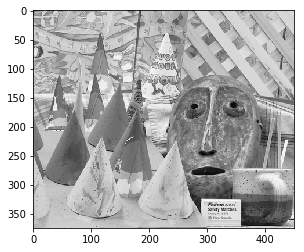

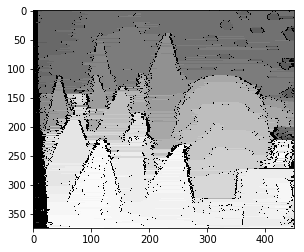

In [0]:
print("GAP PENALTY: {}, EGAP PENALTY: {}, MATCH_SCORE: {}".format(GAP_SCORE, EGAP_SCORE, MATCH_SCORE_TWO_SEQ))
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

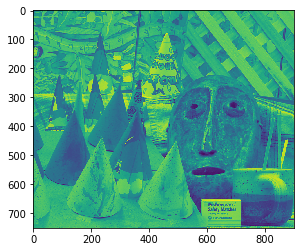

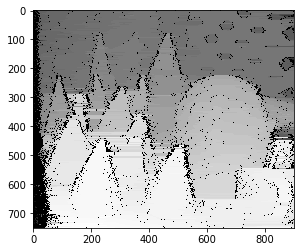

In [0]:
print("GAP PENALTY: {}, EGAP PENALTY: {}, MATCH_SCORE: {}".format(GAP_SCORE, EGAP_SCORE, MATCH_SCORE_TWO_SEQ))
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

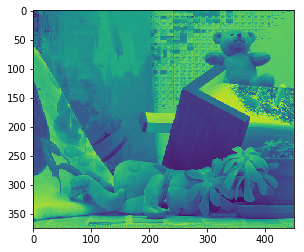

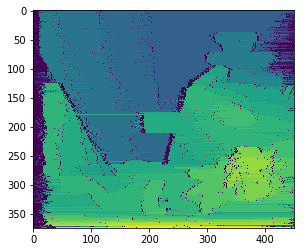

In [0]:
plt.imshow(numpyLeftImg)
plt.show()
plt.imshow(disparityMap)
plt.show()

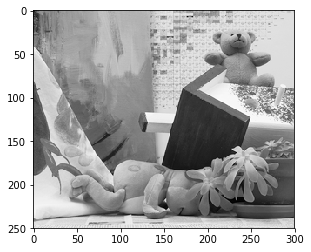

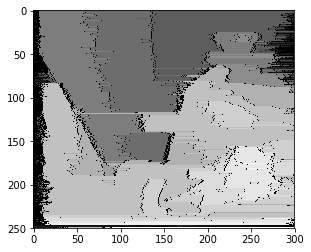

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

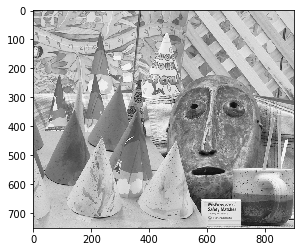

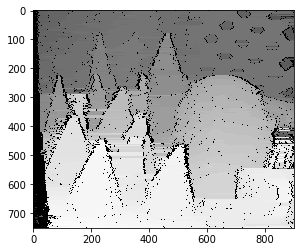

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

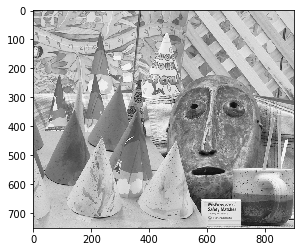

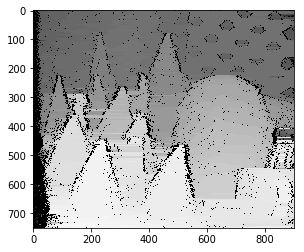

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

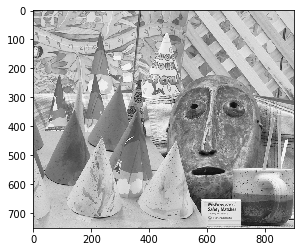

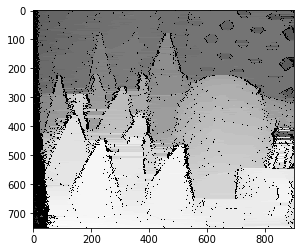

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

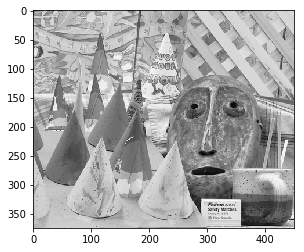

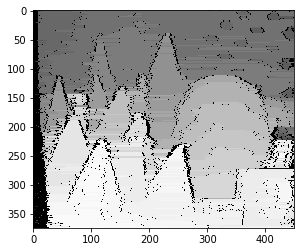

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

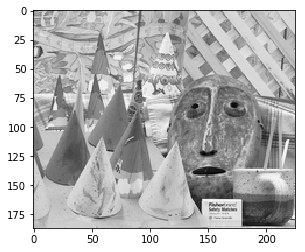

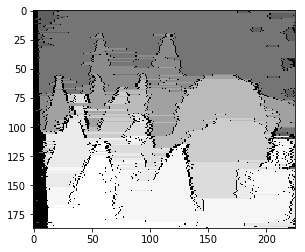

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

GAP PENALTY: -8, EGAP PENALTY: -1, MATCH_SCORE: 60


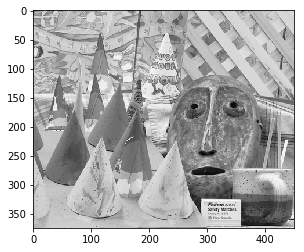

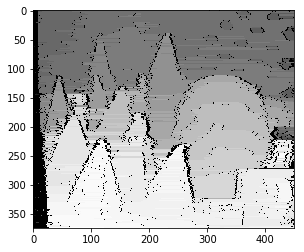

In [0]:
print("GAP PENALTY: {}, EGAP PENALTY: {}, MATCH_SCORE: {}".format(GAP_SCORE, EGAP_SCORE, MATCH_SCORE_TWO_SEQ))
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

GAP PENALTY: -8, EGAP PENALTY: -1, MATCH_SCORE, MISMATCH_SCORE: 60


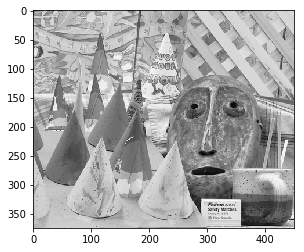

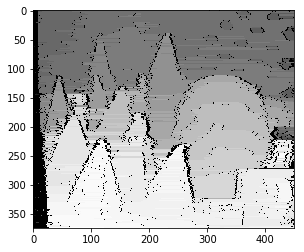

In [0]:
print("GAP PENALTY: {}, EGAP PENALTY: {}, MATCH_SCORE: {}".format(GAP_SCORE, EGAP_SCORE, MATCH_SCORE_TWO_SEQ))
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

GAP PENALTY: -8, EGAP PENALTY: -1, MATCH_SCORE: 60


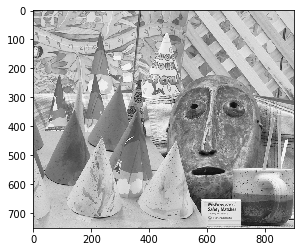

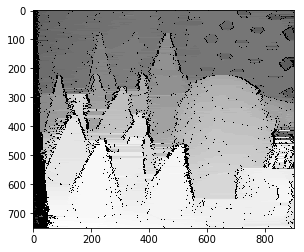

In [0]:
print("GAP PENALTY: {}, EGAP PENALTY: {}, MATCH_SCORE: {}".format(GAP_SCORE, EGAP_SCORE, MATCH_SCORE_TWO_SEQ))
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()